In [268]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import itemfreq
import plotly.offline as py
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import LabelEncoder,minmax_scale,PolynomialFeatures,StandardScaler,Normalizer
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from scipy.stats import itemfreq
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline
py.init_notebook_mode(connected=True)

In [206]:
df = pd.read_csv('C:/Users/msingh/Downloads/CEL_Senior_Data_Scientist_Test/physical_network.csv')
df

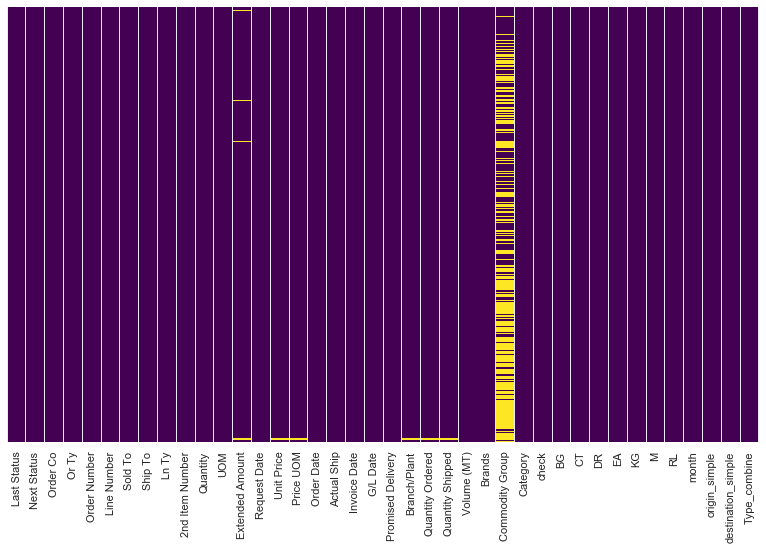

In [217]:
fig, (axis1) = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

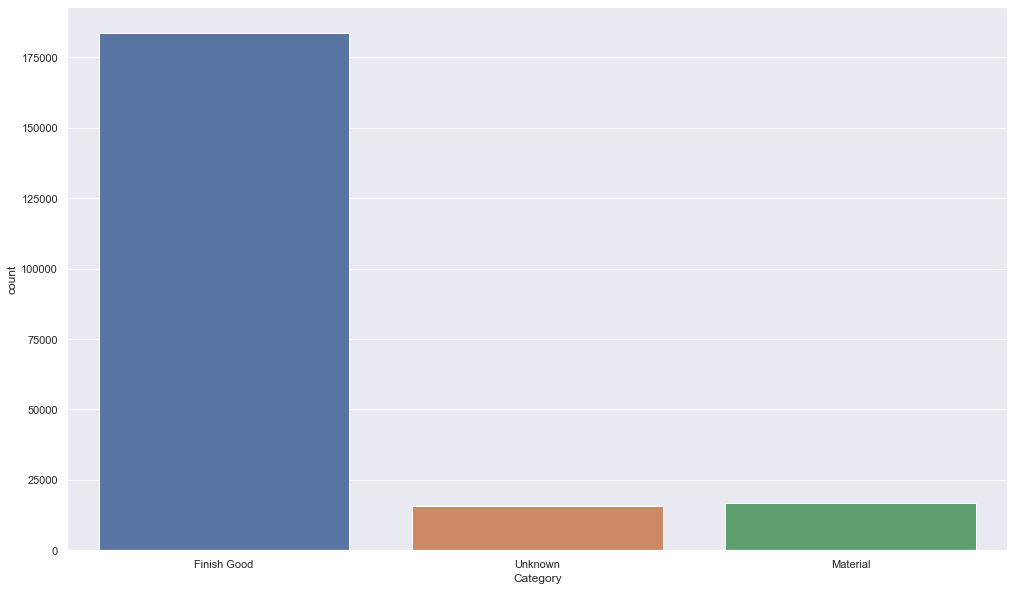

In [214]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
sns.countplot(x='Category', data=df);

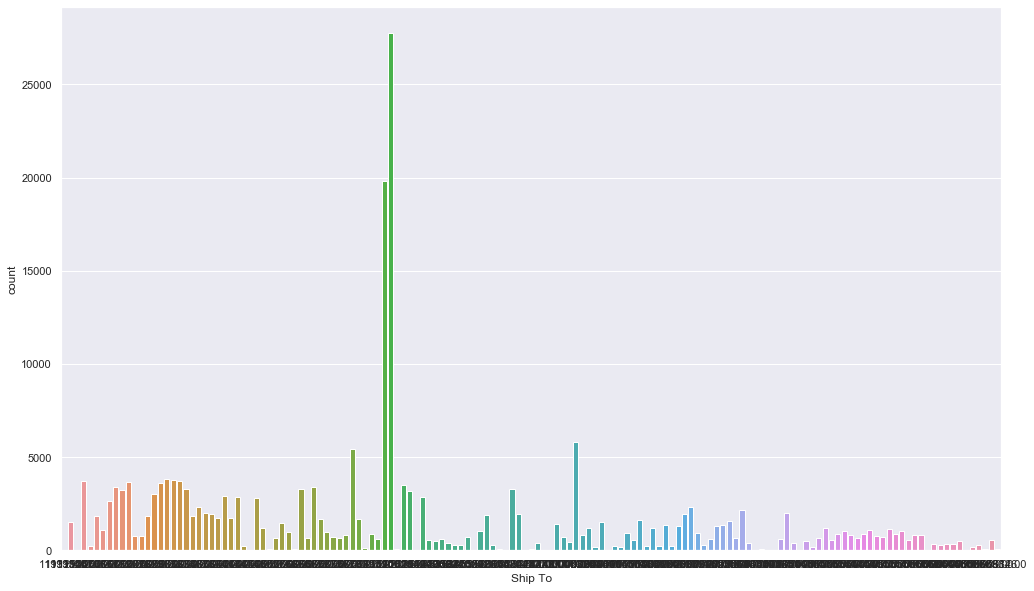

In [219]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
sns.countplot(x='Ship To', data=df);

In [220]:
df['2nd Item Number'].unique

<bound method Series.unique of 0           110455.0
1           113624.0
2           113633.0
3           113626.0
4           115381.0
             ...    
216509    10367046.0
216510    10367049.0
216511           NaN
216512    10350994.0
216513    10374183.0
Name: 2nd Item Number, Length: 216514, dtype: float64>

In [221]:
x=itemfreq(df['2nd Item Number'])
x=x[x[:,1].argsort()[::-1]]

In [222]:
#Fetching the N most purchased products#
def N_most_labels(df, variable , N , all='TRUE'):
    labels_freq_pd = itemfreq(df[variable])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:N]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = df[variable].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_freq_pd, labels_filtered_index

label_freq, labels_filtered_index = N_most_labels(df, variable = "2nd Item Number", N = 20, all='FALSE')
print("labels_filtered_index[0].shape = ", labels_filtered_index[0].shape)

Salesdf_filtered = df.loc[labels_filtered_index[0],:]

labels_filtered_index[0].shape =  (93933,)


In [223]:
label_freq[0:10]

array([[1.0367595e+07, 6.1450000e+03],
       [1.0367594e+07, 6.0750000e+03],
       [1.0374182e+07, 5.4130000e+03],
       [1.1210500e+05, 5.3880000e+03],
       [1.0368214e+07, 5.1310000e+03],
       [1.0370200e+07, 5.0140000e+03],
       [1.0370201e+07, 4.9770000e+03],
       [1.0368215e+07, 4.9140000e+03],
       [1.0374183e+07, 4.9000000e+03],
       [1.0350892e+07, 4.8000000e+03]])

In [224]:
Salesdf_filtered.sample(3)

,Last Status,Next Status,Order Co,Or Ty,Order Number,Line Number,Sold To,Ship To,Ln Ty,2nd Item Number,...,CT,DR,EA,KG,M,RL,month,origin_simple,destination_simple,Type_combine
175965,620.0,999.0,1193.0,UA,600417.0,26.0,2006771.0,2006775.0,S,10368214.0,...,0.0025,0.0,0.000025,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
63202,620.0,999.0,1193.0,UA,594755.0,25.0,2006729.0,2208244.0,S,10374183.0,...,0.0048,0.0,0.000000,0.0,0.0,0.0,9/1/2017,Facilities,Customers,Distribution-Finish Good
16981,620.0,999.0,1193.0,SA,112746.0,18.0,70000240.0,70000238.0,DN,10367598.0,...,0.0060,0.0,0.000000,0.0,0.0,0.0,2/1/2017,Facilities,Customers,Distribution-Finish Good


In [225]:
Salesdf_filtered.isnull().sum()

Last Status               0
Next Status               0
Order Co                  0
Or Ty                     0
Order Number              0
Line Number               0
Sold To                   0
Ship To                   0
Ln Ty                     0
2nd Item Number           0
Quantity                  0
UOM                       0
Extended Amount         188
Request Date              0
Unit Price              105
Price UOM               105
Order Date                0
Actual Ship               0
Invoice Date              0
G/L Date                  0
Promised Delivery         0
Branch/Plant            105
Quantity Ordered        105
Quantity Shipped        105
Volume (MT)               0
Brands                    0
Commodity Group       19767
Category                  0
check                     0
BG                        0
CT                        0
DR                        0
EA                        0
KG                        0
M                         0
RL                  

In [226]:
Salesdf_filtered = Salesdf_filtered.drop(['Commodity Group'], axis=1)

In [227]:
Salesdf_filtered['Order Date'] = pd.to_datetime(Salesdf_filtered['Order Date'], errors='coerce')
Salesdf_filtered['Order Date'] = pd.to_datetime(Salesdf_filtered['Order Date'], format="%Y-%m-%d")
Salesdf_filtered

,Last Status,Next Status,Order Co,Or Ty,Order Number,Line Number,Sold To,Ship To,Ln Ty,2nd Item Number,...,CT,DR,EA,KG,M,RL,month,origin_simple,destination_simple,Type_combine
57,620.0,999.0,1193.0,UA,592131.0,2.0,2693684.0,2384979.0,S,10367594.0,...,0.0060,0.0,0.0,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
58,620.0,999.0,1193.0,UA,592131.0,3.0,2693684.0,2384979.0,S,10367595.0,...,0.0060,0.0,0.0,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
60,620.0,999.0,1193.0,UA,592131.0,5.0,2693684.0,2384979.0,S,10350996.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
61,620.0,999.0,1193.0,UA,592131.0,6.0,2693684.0,2384979.0,S,10350892.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
66,620.0,999.0,1193.0,UA,592132.0,1.0,2006767.0,2006768.0,S,10350996.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216487,620.0,999.0,1193.0,UA,592756.0,7.0,2006748.0,2006748.0,S,10350892.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,3/1/2017,Facilities,Customers,Distribution-Finish Good
216489,620.0,999.0,1193.0,UA,592757.0,10.0,2006746.0,2006746.0,S,10350892.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,3/1/2017,Facilities,Customers,Distribution-Finish Good
216503,620.0,999.0,1193.0,UA,592757.0,28.0,2006746.0,2006746.0,S,10350996.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,3/1/2017,Facilities,Customers,Distribution-Finish Good
216512,620.0,999.0,1193.0,UA,592757.0,41.0,2006746.0,2006746.0,S,10350994.0,...,0.0084,0.0,0.0,0.0,0.0,0.0,3/1/2017,Facilities,Customers,Distribution-Finish Good


In [228]:
Salesdf_filtered['Order Date'] = pd.to_datetime(Salesdf_filtered['Order Date'])
Salesdf_filtered['day'] = Salesdf_filtered['Order Date'].dt.weekday_name
Salesdf_filtered = Salesdf_filtered.drop('Order Date', axis=1)

In [229]:
Salesdf_filtered.sample(10)

,Last Status,Next Status,Order Co,Or Ty,Order Number,Line Number,Sold To,Ship To,Ln Ty,2nd Item Number,...,DR,EA,KG,M,RL,month,origin_simple,destination_simple,Type_combine,day
87133,620.0,999.0,1193.0,UA,595749.0,24.0,2006722.0,2006721.0,S,10374182.0,...,0.0,0.0,0.000,0.0,0.0,1/1/2018,Facilities,Customers,Distribution-Finish Good,Friday
140022,620.0,999.0,1193.0,UA,598159.0,19.0,2006735.0,2006745.0,S,10367595.0,...,0.0,0.0,0.000,0.0,0.0,9/1/2018,Facilities,Customers,Distribution-Finish Good,Tuesday
33766,620.0,999.0,1193.0,UA,593529.0,25.0,2006735.0,2006744.0,S,10367594.0,...,0.0,0.0,0.000,0.0,0.0,5/1/2017,Facilities,Customers,Distribution-Finish Good,Wednesday
82030,620.0,999.0,1193.0,SA,115017.0,5.0,70000246.0,70002311.0,DN,10367598.0,...,0.0,0.0,0.000,0.0,0.0,12/1/2017,Facilities,Customers,Distribution-Finish Good,Thursday
100940,620.0,999.0,1193.0,UA,596253.0,30.0,2006722.0,3587997.0,S,10350996.0,...,0.0,0.0,0.000,0.0,0.0,3/1/2018,Facilities,Customers,Distribution-Finish Good,Friday
69201,620.0,999.0,1193.0,UA,595005.0,18.0,2006767.0,2006768.0,S,10367599.0,...,0.0,0.0,0.000,0.0,0.0,11/1/2017,Facilities,Customers,Distribution-Finish Good,Wednesday
52447,620.0,999.0,2157.0,ST,50007647.0,1.0,2157100.0,2157100.0,S,10367586.0,...,0.0,0.0,0.000,0.0,0.0,8/1/2017,Facilities,Facilities,Transfer-Finish Good,Friday
185794,620.0,999.0,1193.0,SA,117916.0,13.0,2503106.0,2503106.0,DN,10370182.0,...,0.0,0.0,0.000,0.0,0.0,4/1/2019,Facilities,Customers,Distribution-Finish Good,Friday
138923,620.0,999.0,1193.0,SL,116630.0,1.0,70002570.0,70002552.0,S,10350892.0,...,0.0,0.0,0.000,0.0,0.0,9/1/2018,Facilities,Customers,Distribution-Finish Good,Thursday
139486,914.0,999.0,2157.0,ST,50011946.0,1.5,2157101.0,2157101.0,S,112105.0,...,0.0,0.0,0.001,0.0,0.0,9/1/2018,Facilities,Facilities,Transfer-Unknown,Monday


In [230]:
strain = df.sample(frac=0.01,replace=True)

# EDA

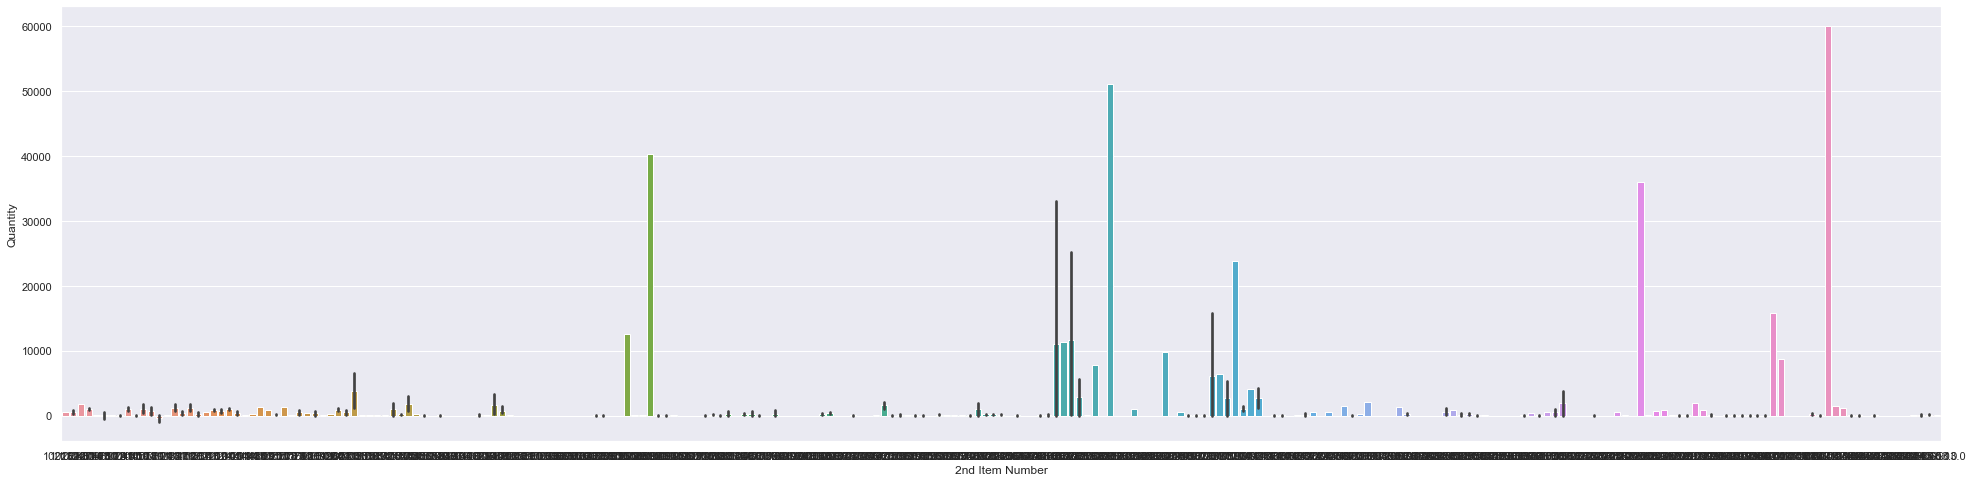

In [232]:
# Plotting Sales per Item Family
fig, (axis1) = plt.subplots(1,1,figsize=(30,8))
sns.barplot(x='2nd Item Number', y='Quantity', data=strain, ax=axis1)

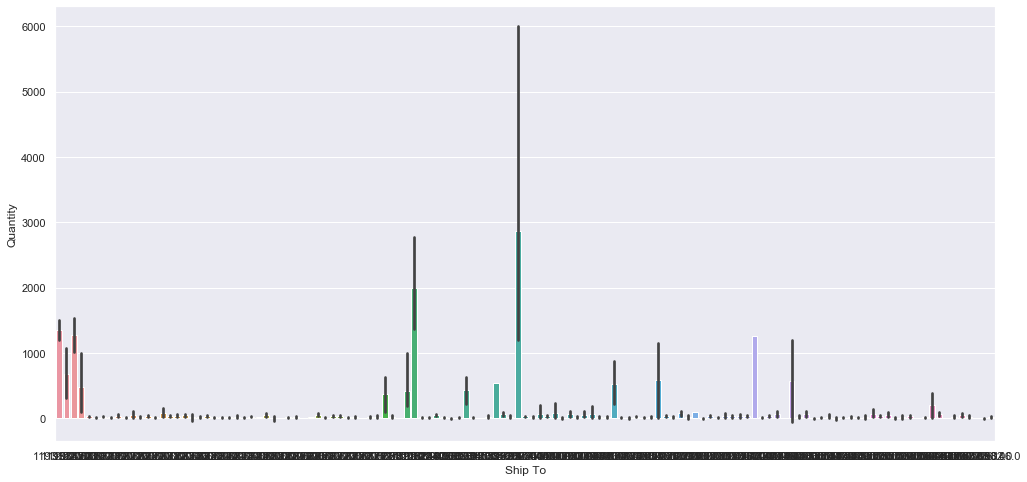

In [233]:
# Plotting Sales per Store Type
fig, (axis1) = plt.subplots(1,1,figsize=(15,8))
sns.barplot(x='Ship To', y='Quantity', data=strain, ax=axis1)

# One hot encoding

In [234]:
dummy_variables = ['Ship To','2nd Item Number','Brands','origin_simple','destination_simple','Type_combine',
                'day','Category','Branch/Plant']
for var in dummy_variables:
    dummy = pd.get_dummies(Salesdf_filtered[var], prefix = var, drop_first = False)
    Salesdf_filtered = pd.concat([Salesdf_filtered, dummy], axis = 1)

Salesdf_filtered = Salesdf_filtered.drop(dummy_variables, axis = 1)
#Salesdf_filtered = Salesdf_filtered.drop(['year'], axis = 1)

In [235]:
Salesdf_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93933 entries, 57 to 216513
Columns: 204 entries, Last Status to Branch/Plant_2157691.0
dtypes: float64(20), object(10), uint8(174)
memory usage: 37.8+ MB


In [236]:
Salesdf_filtered.head()

,Last Status,Next Status,Order Co,Or Ty,Order Number,Line Number,Sold To,Ln Ty,Quantity,UOM,...,Branch/Plant_1193470.0,Branch/Plant_1193475.0,Branch/Plant_1193480.0,Branch/Plant_1193485.0,Branch/Plant_2157100.0,Branch/Plant_2157101.0,Branch/Plant_2157404.0,Branch/Plant_2157411.0,Branch/Plant_2157412.0,Branch/Plant_2157691.0
57,620.0,999.0,1193.0,UA,592131.0,2.0,2693684.0,S,62.0,CT,...,1,0,0,0,0,0,0,0,0,0
58,620.0,999.0,1193.0,UA,592131.0,3.0,2693684.0,S,40.0,CT,...,1,0,0,0,0,0,0,0,0,0
60,620.0,999.0,1193.0,UA,592131.0,5.0,2693684.0,S,144.0,CT,...,1,0,0,0,0,0,0,0,0,0
61,620.0,999.0,1193.0,UA,592131.0,6.0,2693684.0,S,216.0,CT,...,1,0,0,0,0,0,0,0,0,0
66,620.0,999.0,1193.0,UA,592132.0,1.0,2006767.0,S,48.0,CT,...,1,0,0,0,0,0,0,0,0,0


In [237]:
cols = ['Quantity Ordered','Ln Ty','Last Status', 'Next Status','Or Ty', 'Order Co', 'Order Number', 'Line Number', 'Sold To',
        'UOM', 'Extended Amount', 'Request Date', 'Unit Price', 'Price UOM', 'Actual Ship', 'Invoice Date', 'G/L Date',
        'Promised Delivery', 'Quantity Shipped','Volume (MT)','check','BG','CT','DR','EA','KG','M','RL','month']
Salesdf_filtered.drop(cols, axis=1, inplace=True)

In [238]:
min_train, max_train = Salesdf_filtered['Quantity'].min(), Salesdf_filtered['Quantity'].max()

In [239]:
scalable_variables = ['Quantity']
for var in scalable_variables:
    mini, maxi = Salesdf_filtered[var].min(), Salesdf_filtered[var].max()
    Salesdf_filtered.loc[:,var] = (Salesdf_filtered[var] - mini) / (maxi - mini)

In [240]:
print('Shape : ', Salesdf_filtered.shape)
Salesdf_filtered.sample(10)

Shape :  (93933, 175)


,Quantity,Ship To_1193155.0,Ship To_1193470.0,Ship To_2006716.0,Ship To_2006717.0,Ship To_2006718.0,Ship To_2006719.0,Ship To_2006720.0,Ship To_2006721.0,Ship To_2006726.0,...,Branch/Plant_1193470.0,Branch/Plant_1193475.0,Branch/Plant_1193480.0,Branch/Plant_1193485.0,Branch/Plant_2157100.0,Branch/Plant_2157101.0,Branch/Plant_2157404.0,Branch/Plant_2157411.0,Branch/Plant_2157412.0,Branch/Plant_2157691.0
136498,0.010856,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
184409,0.010937,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
28075,0.012613,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83791,0.011207,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
57896,0.011261,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3895,0.021622,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17631,0.011261,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
107041,0.010739,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
145324,0.012829,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
162607,0.010802,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [241]:
Salesdf_filtered.isnull().sum()

Quantity                  0
Ship To_1193155.0         0
Ship To_1193470.0         0
Ship To_2006716.0         0
Ship To_2006717.0         0
                         ..
Branch/Plant_2157101.0    0
Branch/Plant_2157404.0    0
Branch/Plant_2157411.0    0
Branch/Plant_2157412.0    0
Branch/Plant_2157691.0    0
Length: 175, dtype: int64

In [242]:
Salesdf_filtered = Salesdf_filtered.reset_index(drop=True)  #we reset the index
y = Salesdf_filtered['Quantity']
X = Salesdf_filtered.drop(['Quantity'], axis = 1)
print('Shape X :', X.shape)
print('Shape y :', y.shape)

Shape X : (93933, 174)
Shape y : (93933,)


In [243]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (75146, 174)
y_train shape : (75146,)
X_test shape : (18787, 174)
y_test shape : (18787,)


Modles

# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(X_train, y_train)
print(results)

In [244]:
# Print the coefficients
print (results.intercept_, results.coef_)

8539335784.793156 [ 7.55696406e+07 -1.91310588e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  7.41429830e+08
  4.21219265e+07  4.21219265e+07 -1.91310587e+07 -1.91310587e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  4.21219265e+07  4.21219265e+07
  4.21219265e+07  4.21219265e+07  7.55696406e+07  4.21219265e+07
  4.212

In [246]:
ridge = Ridge(alpha=0.1, normalize = True)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
ridge.score(X_test,y_test)

0.13089918945691226

In [170]:
dtr=DecisionTreeRegressor(max_depth=10,min_samples_leaf=5,max_leaf_nodes=5)

In [247]:
dtr.fit(X_train,y_train)
y_pred=dtr.predict(X_test)
print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

##using a decision tree greatly improves the accurancy of model prediction.

R2 score =  0.12805536517189964 / 1.0
MSE score =  5.909339726323201e-05 / 0.0


In [173]:
#random Forrest Regressor
# Choose the type of classifier. 
RFR = RandomForestRegressor()
# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 100],
              'min_samples_leaf': [1,5]
             }
#We have to use RandomForestRegressor's own scorer (which is R^2 score)
#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_
# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [174]:
y_pred = RFR.predict(X_test)
print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.13446448019683765 / 1.0
MSE score =  5.8659038973557944e-05 / 0.0


In [186]:
RFR = RandomForestRegressor()
# Choose some parameter combinations to try
parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1,
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)
RFR = grid_obj.best_estimator_
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 30.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [187]:
y_pred = RFR.predict(X_test)
print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.13437045461580144 / 1.0
MSE score =  5.8665411271512595e-05 / 0.0


In [188]:
#gbr = GradientBoostingRegressor(loss='huber',learning_rate=0.3,n_estimators=100,max_depth=5,min_samples_split=3)
gbr=GradientBoostingRegressor()
parameters = {'n_estimators': [5,10],
              'loss':['huber'],
              'criterion': ['mse'],
              'max_depth': [5,10], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }
#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_
# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.2min finished


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [189]:
y_pred = gbr.predict(X_test)
print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.11644294522094312 / 1.0
MSE score using Gradient Boosting=  5.9880393728305326e-05 / 0.0


# LGBM

In [177]:
from lightgbm import LGBMRegressor
lgbm=LGBMRegressor(max_depth=5)
lgbm.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [178]:
y_pred=lgbm.predict(X_test)
print('R2 score using LGBM = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using LGBM = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using LGBM =  0.18641085296637727 / 1.0
MSE score using LGBM =  5.513853145525718e-05 / 0.0


R square is very poor for all the above model we tried.

Linear Regression - 13%

Decion Tree Regressor- 13%

Random Forrest Regressor - 13.4%

XGBoost Regressor - 11.6%

LGBM Regressor - 18.6%

# I will use Time Series Forecasting

In [279]:
df = pd.read_csv('C:/Users/msingh/Downloads/CEL_Senior_Data_Scientist_Test/physical_network.csv')

In [281]:
# Tried to fix 1899 date
#def get_month_year(date1):
    temp = dt.datetime(1899, 12, 30)
    delta = date1 - temp
    return float(delta.days) + (float(delta.seconds) / 86400)
#get_month_year(Others);

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\msingh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-281-c5b91484d17a>", line 5, in <module>
    get_month_year(Others);
  File "<ipython-input-281-c5b91484d17a>", line 2, in get_month_year
    temp = dt.datetime(1899, 12, 30)    # Note, not 31st Dec but 30th!
NameError: name 'dt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\msingh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\msingh\AppData\Local\Continuum\ana

NameError: name 'dt' is not defined

We will start from the Brands. In brands Chocolate Milk have highest sales. Lets start from that

In [270]:
milk = df.loc[df['Brands'] == 'Chocolate milk']
milk

,Last Status,Next Status,Order Co,Or Ty,Order Number,Line Number,Sold To,Ship To,Ln Ty,2nd Item Number,...,CT,DR,EA,KG,M,RL,month,origin_simple,destination_simple,Type_combine
64,620.0,999.0,1193.0,UA,592131.0,8.0,2693684.0,2384979.0,S,10367597.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
78,620.0,999.0,1193.0,UA,592132.0,3.0,2006767.0,2006768.0,S,10367591.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
79,620.0,999.0,1193.0,UA,592132.0,4.0,2006767.0,2006768.0,S,10367598.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
80,620.0,999.0,1193.0,UA,592132.0,5.0,2006767.0,2006768.0,S,10367597.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
81,914.0,999.0,1193.0,UA,592132.0,5.1,2006767.0,2006768.0,S,10367597.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214701,620.0,999.0,1193.0,UA,600362.0,13.0,70000240.0,70000238.0,S,10399348.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
214702,620.0,999.0,1193.0,UA,600362.0,14.0,70000240.0,70000238.0,S,10399362.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
214724,620.0,999.0,1193.0,UA,600362.0,7.0,70000240.0,70000238.0,S,10399470.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
214725,620.0,999.0,1193.0,UA,600362.0,8.0,70000240.0,70000238.0,S,10399351.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good


In [271]:
milk['Order Date'] = pd.to_datetime(milk['Order Date'], errors='coerce')
milk['Order Date'] = pd.to_datetime(milk['Order Date'], format="%Y-%m-%d")
milk

,Last Status,Next Status,Order Co,Or Ty,Order Number,Line Number,Sold To,Ship To,Ln Ty,2nd Item Number,...,CT,DR,EA,KG,M,RL,month,origin_simple,destination_simple,Type_combine
64,620.0,999.0,1193.0,UA,592131.0,8.0,2693684.0,2384979.0,S,10367597.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
78,620.0,999.0,1193.0,UA,592132.0,3.0,2006767.0,2006768.0,S,10367591.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
79,620.0,999.0,1193.0,UA,592132.0,4.0,2006767.0,2006768.0,S,10367598.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
80,620.0,999.0,1193.0,UA,592132.0,5.0,2006767.0,2006768.0,S,10367597.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
81,914.0,999.0,1193.0,UA,592132.0,5.1,2006767.0,2006768.0,S,10367597.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,1/1/2017,Facilities,Customers,Distribution-Finish Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214701,620.0,999.0,1193.0,UA,600362.0,13.0,70000240.0,70000238.0,S,10399348.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
214702,620.0,999.0,1193.0,UA,600362.0,14.0,70000240.0,70000238.0,S,10399362.0,...,0.0108,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
214724,620.0,999.0,1193.0,UA,600362.0,7.0,70000240.0,70000238.0,S,10399470.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good
214725,620.0,999.0,1193.0,UA,600362.0,8.0,70000240.0,70000238.0,S,10399351.0,...,0.0060,0.0,0.00000,0.0,0.0,0.0,3/1/2019,Facilities,Customers,Distribution-Finish Good


In [272]:
cols = ['Quantity Ordered','Ln Ty','Last Status', 'Next Status','Or Ty', 'Order Co', 'Order Number', 'Line Number', 'Sold To', 'Ship To', '2nd Item Number',
        'UOM', 'Extended Amount', 'Request Date', 'Unit Price', 'Price UOM', 'Actual Ship', 'Invoice Date', 'G/L Date',
        'Promised Delivery', 'Branch/Plant', 'Quantity Shipped','Volume (MT)','Brands','Commodity Group','Category','check',
       'BG','CT','DR','EA','KG','M','RL','month','origin_simple','destination_simple','Type_combine']
milk.drop(cols, axis=1, inplace=True)
milk = milk.sort_values('Order Date')
milk.isnull().sum()

Quantity      0
Order Date    0
dtype: int64

In [273]:
milk = milk.groupby('Order Date')['Quantity'].sum().reset_index()

In [274]:
milk = milk.set_index('Order Date')
milk.index

DatetimeIndex(['2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31',
               '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07',
               ...
               '2019-09-02', '2019-09-03', '2019-10-01', '2019-10-02',
               '2019-11-01', '2019-11-02', '2019-11-03', '2019-12-01',
               '2019-12-02', '2019-12-03'],
              dtype='datetime64[ns]', name='Order Date', length=698, freq=None)

In [81]:
#milk.drop(pd.to_datetime('1899-12-30'))

,Quantity
Order Date,
2016-12-28,2107.0
2016-12-29,5943.0
2016-12-30,145020.0
2016-12-31,766.0
2017-01-02,6616.0
...,...
2019-11-02,56206.0
2019-11-03,7078.0
2019-12-01,33408.0


In [275]:
y = milk['Quantity'].resample('MS').mean()

In [276]:
y['2016':]

Order Date
2016-12-01    38459.000000
2017-01-01    37171.730769
2017-02-01    39522.086957
2017-03-01    34312.840000
2017-04-01    32185.190476
2017-05-01    35583.600000
2017-06-01    31940.888889
2017-07-01    48382.913043
2017-08-01    38940.086957
2017-09-01    35333.130435
2017-10-01    28318.652174
2017-11-01    29036.921600
2017-12-01    36642.440000
2018-01-01    47439.814815
2018-02-01    41614.095238
2018-03-01    26220.708333
2018-04-01    25984.652174
2018-05-01    61964.782609
2018-06-01    30979.500000
2018-07-01    29366.840000
2018-08-01    39370.840000
2018-09-01    50276.173913
2018-10-01    39961.730769
2018-11-01    28974.520000
2018-12-01    22887.250000
2019-01-01    35847.312500
2019-02-01    21642.312500
2019-03-01    30751.750000
2019-04-01    41541.880000
2019-05-01    36500.192308
2019-06-01    44921.882353
2019-07-01    30879.000000
2019-08-01    24335.000000
2019-09-01    60723.000000
2019-10-01    27134.000000
2019-11-01    25033.333333
2019-12-01    567

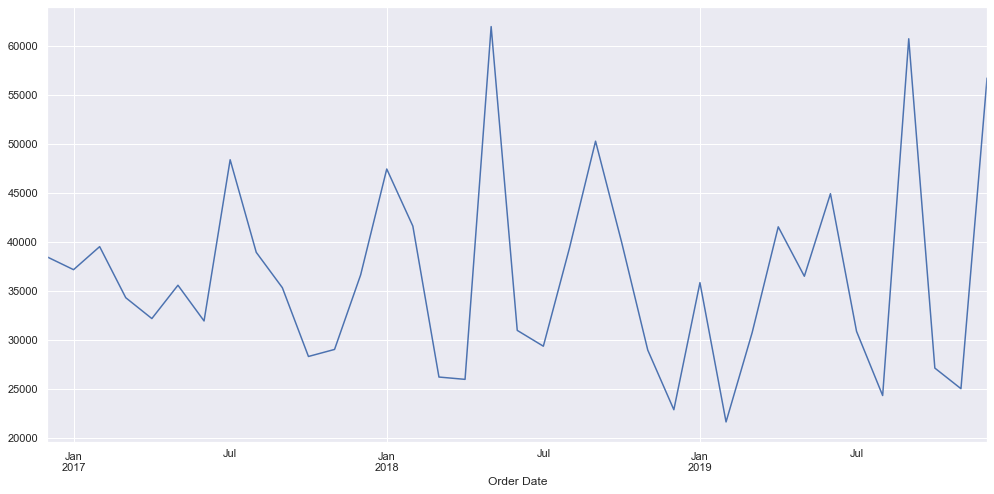

In [277]:
y.plot(figsize=(15, 8))
plt.show()

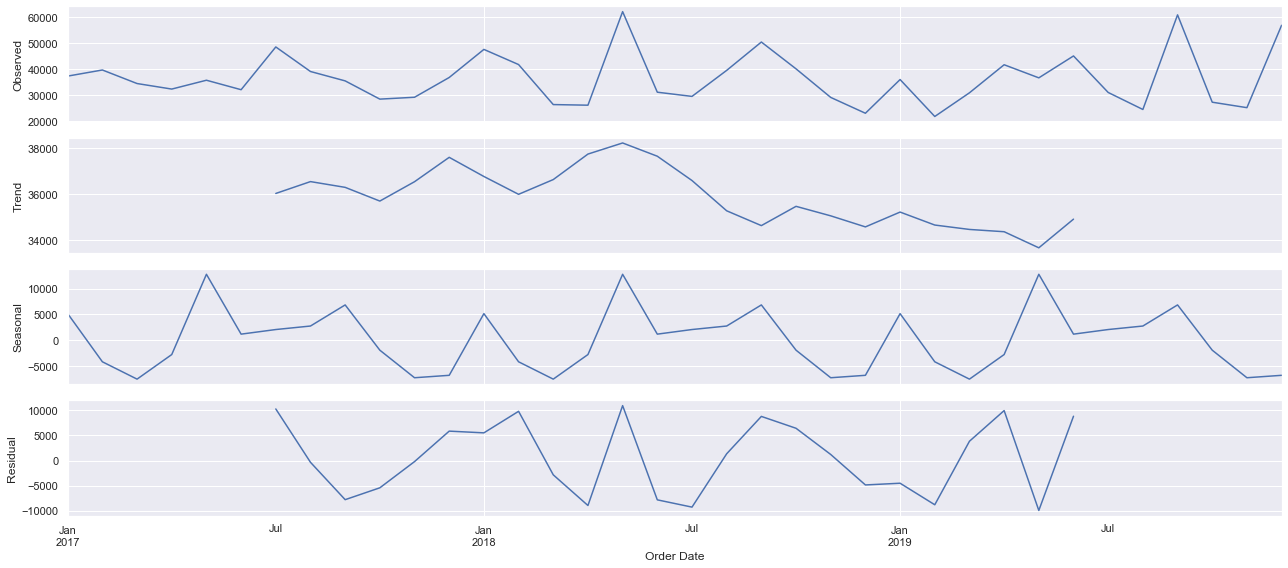

In [278]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y['2017':], model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of Chocolate Milk is unstable, along with its obvious seasonality

# Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [55]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. Lets pick the best combination of pdq.

In [57]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:862.8594197556084
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:530.6292299359964
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:553.0455631706011
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:288.0058078263462
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:821.0915562024614
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14890.85185707087
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:509.0830598237216
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:582.2445621959733
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:538.0316374559657
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:287.667806744834
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:775.1950517747415
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:525.938505786989
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:541.4459780357893
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:275.7488332600603
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:732.4848246117097
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:496.3049307291983
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:524

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) and ARIMA(1, 1, 0)x(1, 1, 0, 12)12 yields the lowest AIC value of 252.55 and AIC:252.900 respectively. Therefore we should consider these two to be optimal option for us.Lets try one by one and we will pick the best out of these two based on RMSE value.

First Try-  ARIMA(1, 1, 1)x(1, 1, 0, 12)12 with AIC:252.55

In [58]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3707      0.989     -0.375      0.708      -2.309       1.567
ma.L1         -0.6712      0.385     -1.745      0.081      -1.425       0.083
ar.S.L12      -0.5594      0.559     -1.001      0.317      -1.655       0.536
sigma2      4.037e+08   2.72e-10   1.48e+18      0.000    4.04e+08    4.04e+08


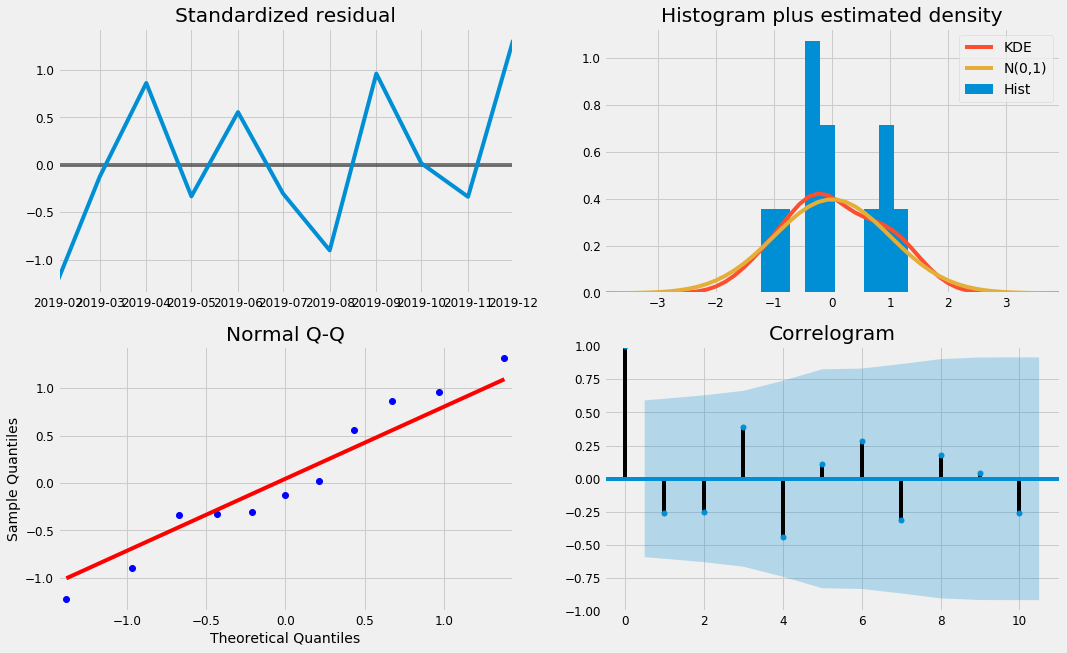

In [59]:
results.plot_diagnostics(figsize=(16, 10))
plt.show()

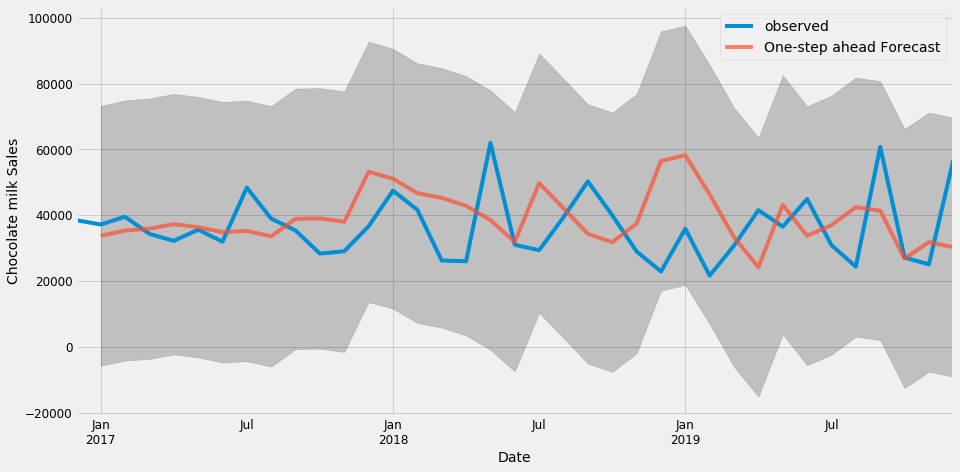

In [60]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Chocolate milk Sales')
plt.legend()
plt.show()

In [61]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 194406496.85


In [62]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 13942.97


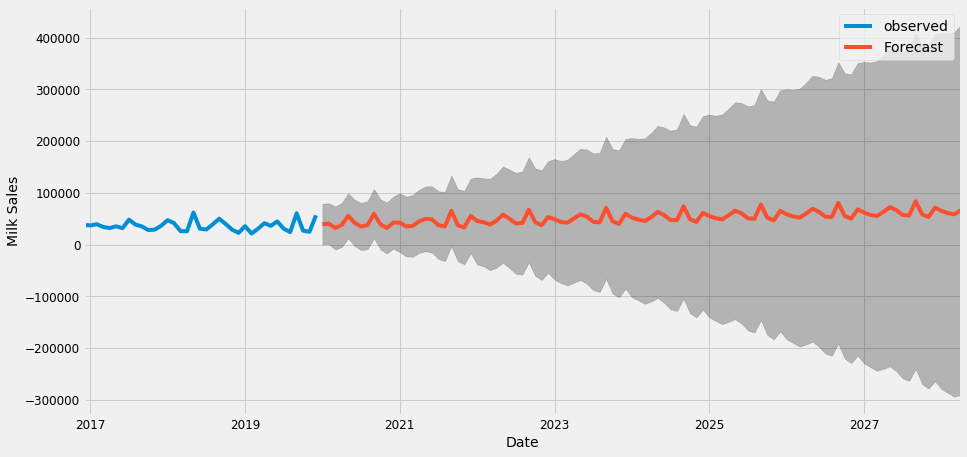

In [63]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Milk Sales')
plt.legend()
plt.show()

Second Try ARIMA(1, 1, 0)x(1, 1, 0, 12)12 with AIC:252.90

In [136]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5494      0.492     -1.117      0.264      -1.513       0.415
ar.S.L12      -0.6881      0.324     -2.123      0.034      -1.323      -0.053
sigma2       3.93e+08   2.44e-10   1.61e+18      0.000    3.93e+08    3.93e+08


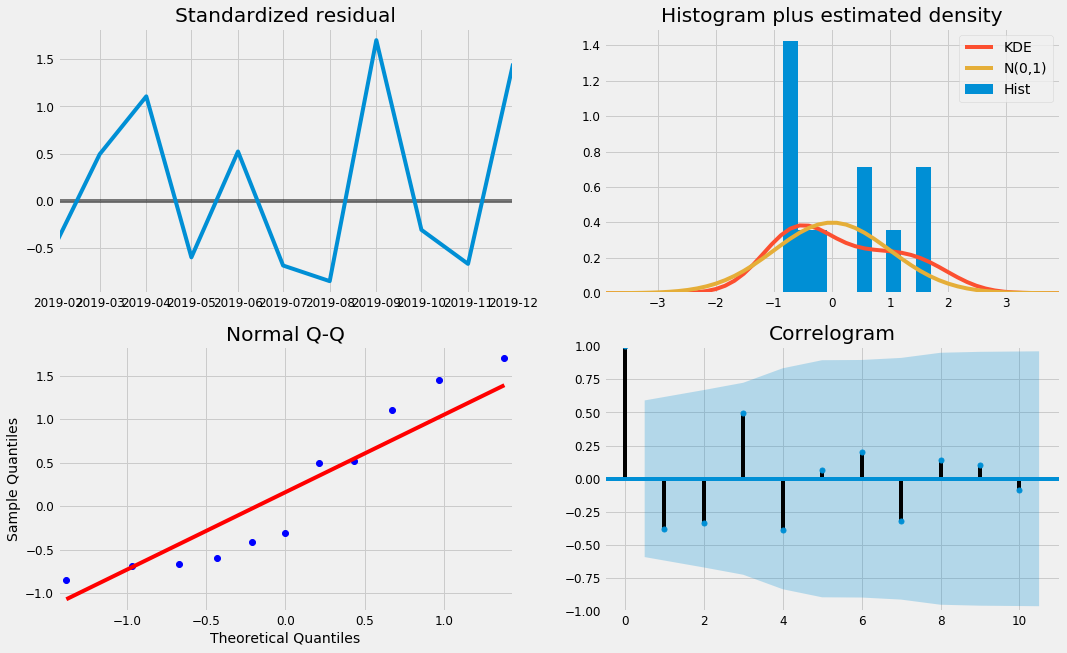

In [137]:
results.plot_diagnostics(figsize=(16, 10))
plt.show()

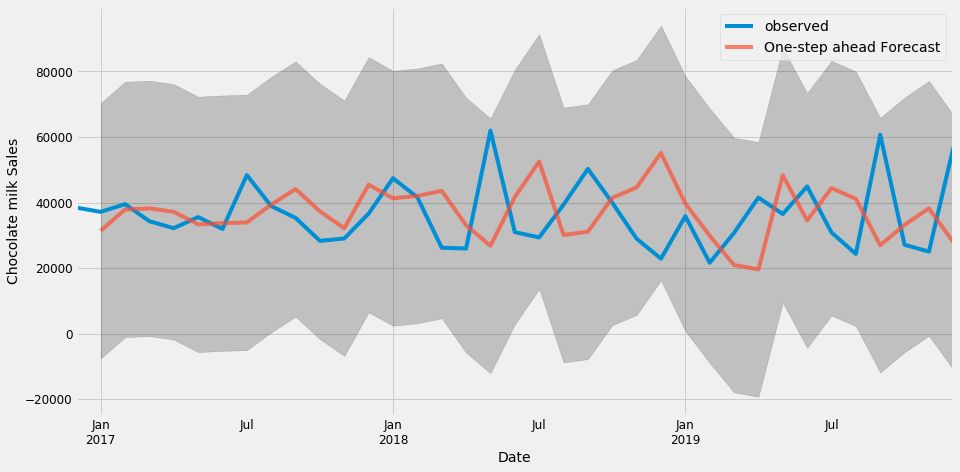

In [138]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Chocolate milk Sales')
plt.legend()
plt.show()

In [139]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 225202926.65


In [140]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 15006.76


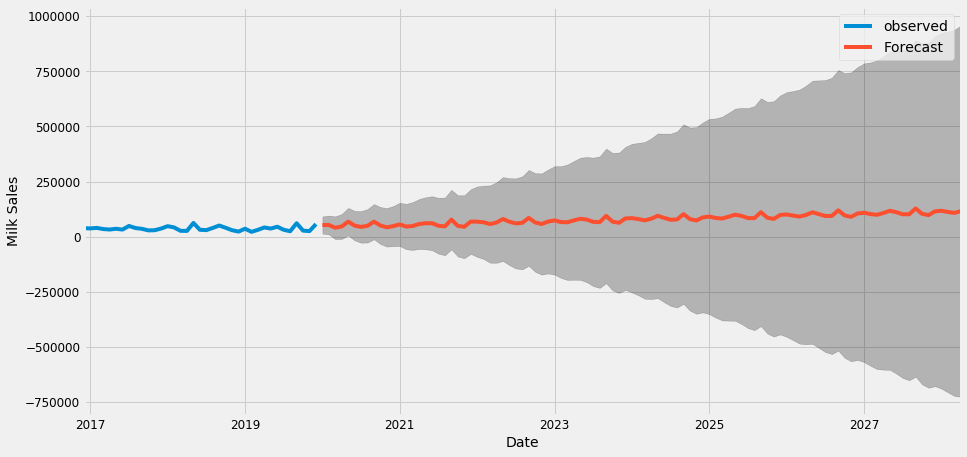

In [141]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Milk Sales')
plt.legend()
plt.show()

# Now we will forecast Cholocate Milk and Coconut milk sales. 

In [155]:
ChocolateMilk = df.loc[df['Brands'] == 'Chocolate milk']
CoconutMilk = df.loc[df['Brands'] == 'Coconut milk']
ChocolateMilk.shape, CoconutMilk.shape

((53168, 40), (49079, 40))

In [156]:
CoconutMilk['Order Date'] = pd.to_datetime(CoconutMilk['Order Date'], errors='coerce')
CoconutMilk['Order Date'] = pd.to_datetime(CoconutMilk['Order Date'], format="%Y-%m-%d")
ChocolateMilk['Order Date'] = pd.to_datetime(ChocolateMilk['Order Date'], errors='coerce')
ChocolateMilk['Order Date'] = pd.to_datetime(ChocolateMilk['Order Date'], format="%Y-%m-%d")


In [157]:
cols = ['Quantity Ordered','Ln Ty','Last Status', 'Next Status','Or Ty', 'Order Co', 'Order Number', 'Line Number', 'Sold To', 'Ship To', '2nd Item Number',
        'UOM', 'Extended Amount', 'Request Date', 'Unit Price', 'Price UOM', 'Actual Ship', 'Invoice Date', 'G/L Date',
        'Promised Delivery', 'Branch/Plant', 'Quantity Shipped','Volume (MT)','Brands','Commodity Group','Category','check',
       'BG','CT','DR','EA','KG','M','RL','month','origin_simple','destination_simple','Type_combine']
ChocolateMilk.drop(cols, axis=1, inplace=True)
CoconutMilk.drop(cols, axis=1, inplace=True)

ChocolateMilk = ChocolateMilk.sort_values('Order Date')
CoconutMilk = CoconutMilk.sort_values('Order Date')
ChocolateMilk = ChocolateMilk.groupby('Order Date')['Quantity'].sum().reset_index()
CoconutMilk = CoconutMilk.groupby('Order Date')['Quantity'].sum().reset_index()
ChocolateMilk = ChocolateMilk.set_index('Order Date')
CoconutMilk = CoconutMilk.set_index('Order Date')

In [158]:
ChocolateMilk = ChocolateMilk.groupby('Order Date')['Quantity'].sum().reset_index()
ChocolateMilk = ChocolateMilk.set_index('Order Date')
ChocolateMilk.index

DatetimeIndex(['2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31',
               '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07',
               ...
               '2019-09-02', '2019-09-03', '2019-10-01', '2019-10-02',
               '2019-11-01', '2019-11-02', '2019-11-03', '2019-12-01',
               '2019-12-02', '2019-12-03'],
              dtype='datetime64[ns]', name='Order Date', length=698, freq=None)

In [159]:
CoconutMilk = CoconutMilk.groupby('Order Date')['Quantity'].sum().reset_index()
CoconutMilk = CoconutMilk.set_index('Order Date')
CoconutMilk.index

DatetimeIndex(['2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31',
               '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07',
               ...
               '2019-09-02', '2019-09-03', '2019-10-01', '2019-10-02',
               '2019-11-01', '2019-11-02', '2019-11-03', '2019-12-01',
               '2019-12-02', '2019-12-03'],
              dtype='datetime64[ns]', name='Order Date', length=700, freq=None)

In [160]:
y_ChocolateMilk = ChocolateMilk['Quantity'].resample('MS').mean()
y_CoconutMilk = CoconutMilk['Quantity'].resample('MS').mean()

In [161]:
ChocolateMilk = pd.DataFrame({'Order Date':y_ChocolateMilk.index, 'Quantity':y_ChocolateMilk.values})
CoconutMilk = pd.DataFrame({'Order Date': y_CoconutMilk.index, 'Quantity': y_CoconutMilk.values})

In [162]:
store = ChocolateMilk.merge(CoconutMilk, how='inner', on='Order Date')
store.rename(columns={'Quantity_x': 'ChocolateMilk_sales', 'Quantity_y': 'CoconutMilk_sales'}, inplace=True)
store.head()

,Order Date,ChocolateMilk_sales,CoconutMilk_sales
0,2016-12-01,38459.000000,13810.000000
1,2017-01-01,37171.730769,17473.320000
2,2017-02-01,39522.086957,24836.478261
3,2017-03-01,34312.840000,11880.833333
4,2017-04-01,32185.190476,19534.452381


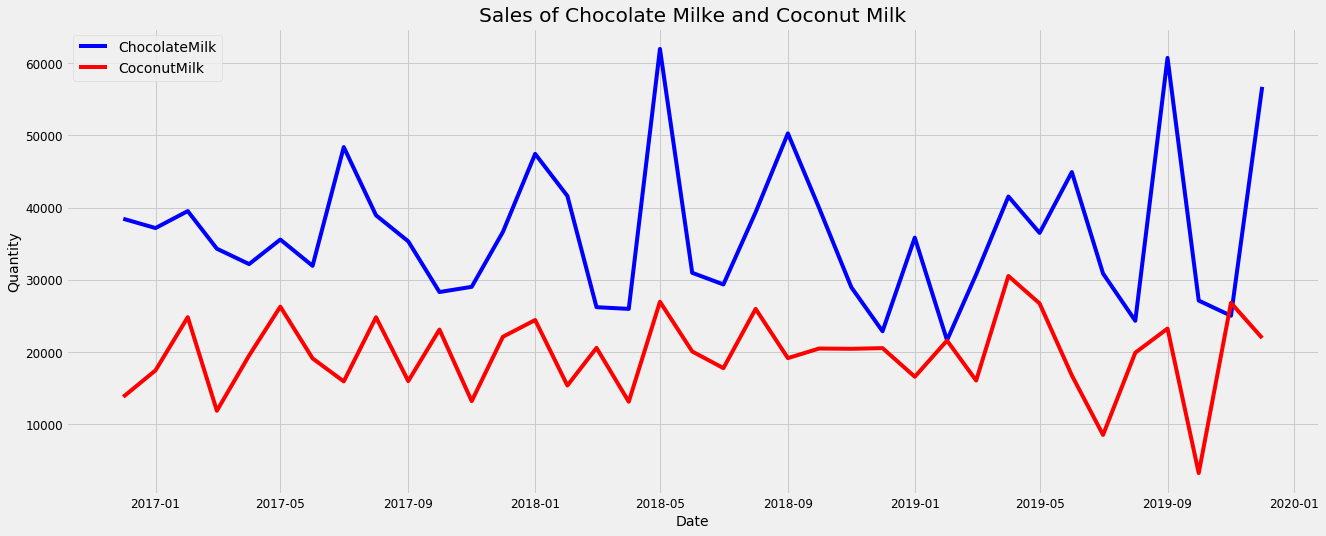

In [163]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['ChocolateMilk_sales'], 'b-', label = 'ChocolateMilk')
plt.plot(store['Order Date'], store['CoconutMilk_sales'], 'r-', label = 'CoconutMilk')
plt.xlabel('Date'); plt.ylabel('Quantity'); plt.title('Sales of Chocolate Milke and Coconut Milk')
plt.legend();

In [164]:
first_date = store.ix[np.min(list(np.where(store['CoconutMilk_sales'] > store['ChocolateMilk_sales'])[0])), 'Order Date']
print("CoconutMilk sales first time produced higher sales than Chocolate Milk is {}.".format(first_date.date()))

CoconutMilk sales first time produced higher sales than Chocolate Milk is 2019-11-01.


Generally Chocolate Milk sales are higher than Coconut milk but first time on 2019-11-01 coconut milk sales were higher than Chocolate milk sales

In [168]:
from fbprophet import Prophet
ChocolateMilk = ChocolateMilk.rename(columns={'Order Date': 'ds', 'Quantity': 'y'})
ChocolateMilk_model = Prophet(interval_width=0.95)
ChocolateMilk_model.fit(ChocolateMilk)
CoconutMilk = CoconutMilk.rename(columns={'Order Date': 'ds', 'Quantity': 'y'})
CoconutMilk_model = Prophet(interval_width=0.95)
CoconutMilk_model.fit(CoconutMilk)
ChocolateMilk_forecast = ChocolateMilk_model.make_future_dataframe(periods=36, freq='MS')
ChocolateMilk_forecast = ChocolateMilk_model.predict(ChocolateMilk_forecast)
CoconutMilk_forecast = CoconutMilk_model.make_future_dataframe(periods=36, freq='MS')
CoconutMilk_forecast = CoconutMilk_model.predict(CoconutMilk_forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

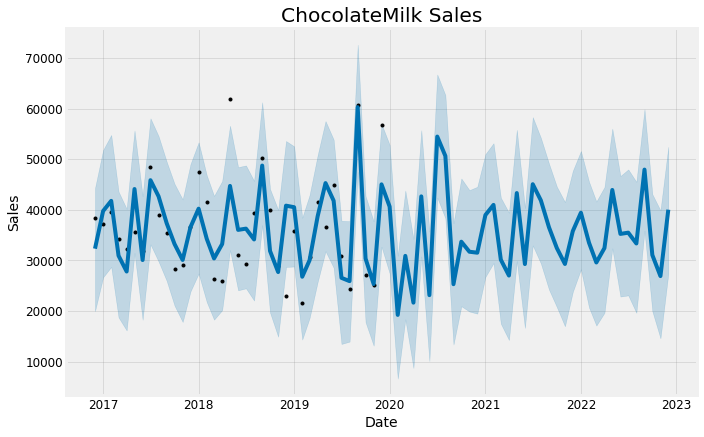

In [171]:
plt.figure(figsize=(18, 6))
ChocolateMilk_model.plot(ChocolateMilk_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('ChocolateMilk Sales');

<Figure size 1296x432 with 0 Axes>

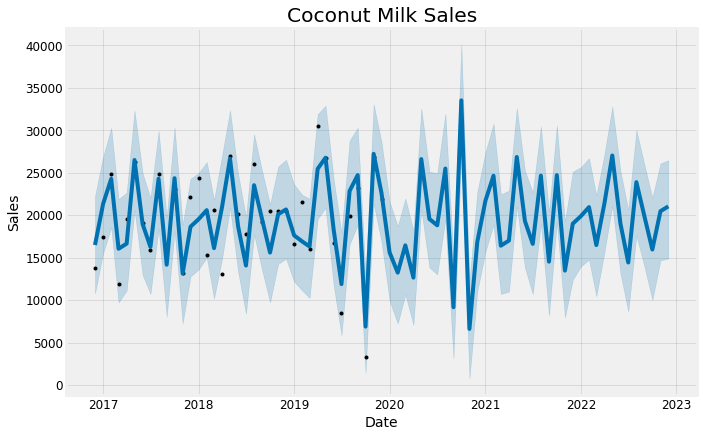

In [170]:
plt.figure(figsize=(18, 6))
CoconutMilk_model.plot(CoconutMilk_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Coconut Milk Sales');

Compare Forcasts

In [172]:
ChocolateMilk_names = ['ChocolateMilk_%s' % column for column in ChocolateMilk_forecast.columns]
CoconutMilk_names = ['CoconutMilk_%s' % column for column in CoconutMilk_forecast.columns]
merge_ChocolateMilk_forecast = ChocolateMilk_forecast.copy()
merge_CoconutMilk_forecast = CoconutMilk_forecast.copy()
merge_ChocolateMilk_forecast.columns = ChocolateMilk_names
merge_CoconutMilk_forecast.columns = CoconutMilk_names
forecast = pd.merge(merge_ChocolateMilk_forecast, merge_CoconutMilk_forecast, how = 'inner', left_on = 'ChocolateMilk_ds', right_on = 'CoconutMilk_ds')
forecast = forecast.rename(columns={'ChocolateMilk_ds': 'Date'}).drop('CoconutMilk_ds', axis=1)
forecast.head()

,Date,ChocolateMilk_trend,ChocolateMilk_yhat_lower,ChocolateMilk_yhat_upper,ChocolateMilk_trend_lower,ChocolateMilk_trend_upper,ChocolateMilk_additive_terms,ChocolateMilk_additive_terms_lower,ChocolateMilk_additive_terms_upper,ChocolateMilk_yearly,...,CoconutMilk_additive_terms,CoconutMilk_additive_terms_lower,CoconutMilk_additive_terms_upper,CoconutMilk_yearly,CoconutMilk_yearly_lower,CoconutMilk_yearly_upper,CoconutMilk_multiplicative_terms,CoconutMilk_multiplicative_terms_lower,CoconutMilk_multiplicative_terms_upper,CoconutMilk_yhat
0,2016-12-01,35949.248028,19957.751796,44265.199518,35949.248028,35949.248028,-3639.513992,-3639.513992,-3639.513992,-3639.513992,...,-2736.390980,-2736.390980,-2736.390980,-2736.390980,-2736.390980,-2736.390980,0.0,0.0,0.0,16495.310192
1,2017-01-01,35932.333280,26656.208309,51809.222558,35932.333280,35932.333280,3819.941342,3819.941342,3819.941342,3819.941342,...,2097.971087,2097.971087,2097.971087,2097.971087,2097.971087,2097.971087,0.0,0.0,0.0,21337.347167
2,2017-02-01,35915.418533,28706.180440,54791.102547,35915.418533,35915.418533,5847.139106,5847.139106,5847.139106,5847.139106,...,5049.397642,5049.397642,5049.397642,5049.397642,5049.397642,5049.397642,0.0,0.0,0.0,24296.448628
3,2017-03-01,35900.140696,18725.762340,43588.268214,35900.140696,35900.140696,-4969.036098,-4969.036098,-4969.036098,-4969.036098,...,-3199.980448,-3199.980448,-3199.980448,-3199.980448,-3199.980448,-3199.980448,0.0,0.0,0.0,16054.002710
4,2017-04-01,35883.225947,16143.975964,40180.924345,35883.225947,35883.225947,-8092.870287,-8092.870287,-8092.870287,-8092.870287,...,-2601.016245,-2601.016245,-2601.016245,-2601.016245,-2601.016245,-2601.016245,0.0,0.0,0.0,16660.641820


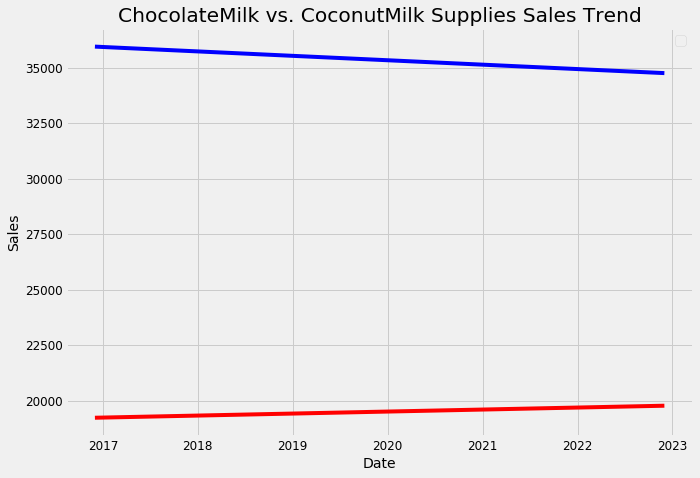

In [173]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['ChocolateMilk_trend'], 'b-')
plt.plot(forecast['Date'], forecast['CoconutMilk_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('ChocolateMilk vs. CoconutMilk Supplies Sales Trend');

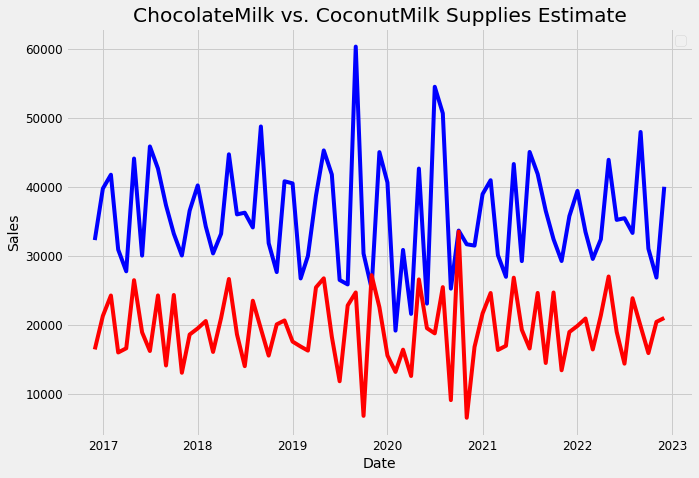

In [174]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['ChocolateMilk_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['CoconutMilk_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('ChocolateMilk vs. CoconutMilk Supplies Estimate');

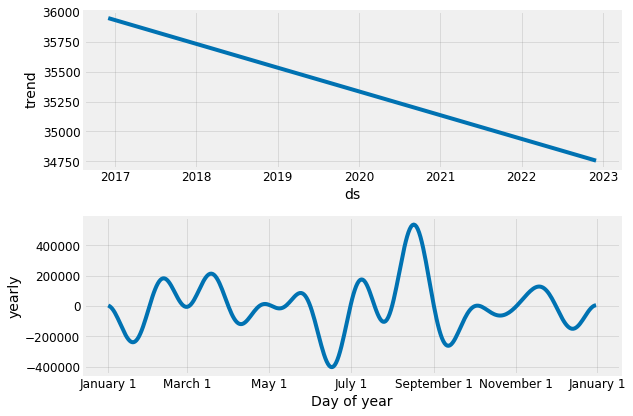

In [175]:
ChocolateMilk_model.plot_components(ChocolateMilk_forecast);

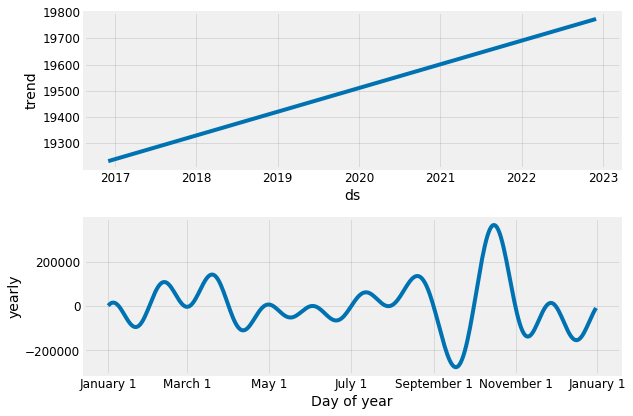

In [176]:
CoconutMilk_model.plot_components(CoconutMilk_forecast);

We can use more advanced models to improve this forecast.
Neural Network would be a good Idea.